# BayesLOSVD and DYNAMITE

This notebook will show how to run DYNAMITE orbit-based models using [BayesLOSVD](https://github.com/jfalconbarroso/BAYES-LOSVD) output. BayesLOSVD is a Python library for the non-parametric extraction of the Line-Of-Sight Velocity Distributions (LOSVDs) in galaxies. Rather than describe the LOSVD using Gauss-Hermite expansion, BayesLOSVD represents the LOSVD in a *histogram* format.

1. [An example galaxy: NGC4550](#NGC4550)
2. [Data prepearion](#datprep)
3. [A look at the BayesLOSVD data](#data_firstlook)
4. [Running DYNMAITE](#run_dyn)

<a id="NGC4550"></a>
## An example galaxy: NGC4550

We will model the galaxy NGC4550, which has a complex LOSVD. The following is taken from Figure 7 of Falcón-Barroso & Martig 2020, showing LOSVDs extracted using BayesLOSVD at three regions,

<img src="NGC4550_input/bayeslosvd_extractions.png" width="400">

We see clearly bimodal LOSVDs in the galaxy outskirts, indicating a strong counter-rotating stellar component.

<a id="datprep"></a>
## Data preparation

We require the ``*_results.hdf5`` output file from BayesLOSVD. Two such files for NGC4550 have been kindly provided by Jesus Falcón-Barroso, and can be found in the directory `NGC4550_input`. They differ in the form of LOSVD regularisation used,
- `NGC4550_SAURON-SP_results.hdf5`: using simplex regularisation
- `NGC4550_SAURON-RW_results.hdf5`: using random walk regularisation

These ``*_results.hdf5`` files contains LOSVD constraints for all spatial regions. For more details, and instructions on creating your own ``*_results.hdf5`` files, see the [BayesLOSVD](https://github.com/jfalconbarroso/BAYES-LOSVD) documentation.

To prepeare this data for use in DYNAMITE, we must

1. convert kinematics to Astropy ECSV file format
2. add the PSF to the kinematics file header
3. create the auxillary `aperture.dat` and `bins.dat` files
4. get MGE data (in Astropy ECSV format)

This can be done as follows,

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import dynamite as dyn
print('Using DYNAMITE version:', dyn.__version__)
    
BayesLOSVD = dyn.kinematics.BayesLOSVD(weight=1.,
                                       hist_width=1,
                                       hist_center=0,
                                       hist_bins=0,
                                       type='BayesLOSVD')
infile = 'NGC4550_input/NGC4550_SAURON-SP_results.hdf5'
outfile = 'NGC4550_input/dynamite_input/bayes_losvd_kins.ecsv'
BayesLOSVD.write_losvds_to_ecsv_format(infile, outfile=outfile)

Using DYNAMITE version: 2.0.0


We next add the PSF to the kinematics. The seeing - from Table 3 of [Emsellem et al 2004](https://academic.oup.com/mnras/article/352/3/721/1210712) - has FWHM of 2.1 arcsec. We convert this to a Gaussian sigma, and add to the header of the kinematics file,

In [2]:
seeing_fwhm = 2.1
seeing_gauss_sigma = seeing_fwhm/2.35
# add the psf to file header
BayesLOSVD.add_psf_to_datafile(sigma=[seeing_gauss_sigma],
                               weight=[1.],
                               datafile=outfile)

# re-create the BayesLOSVD object reading in the complete kinematics file
BayesLOSVD = dyn.kinematics.BayesLOSVD(datafile=outfile,
                                       weight=1.,
                                       type='BayesLOSVD')

Next create the auxillary `aperture.dat` and `bins.dat` files. This will require the galaxy's position angle. Table 3 of [Emsellem et al 2004](https://academic.oup.com/mnras/article/352/3/721/1210712), gives PA = 0.

In [3]:
position_angle = 0.
angle_deg = 90. - position_angle
dyn_input_direc = 'NGC4550_input/dynamite_input/'
BayesLOSVD.write_aperture_and_bin_files(filename=infile,
                                        angle_deg=angle_deg,
                                        aperture_filename=dyn_input_direc+'aperture.dat',
                                        bin_filename=dyn_input_direc+'bins.dat')

Finally we need the Multi Gaussian Expansion. MGEs for Atlas3D galaxies (including NGC4550) can be found under the link for the *MGE parameters for the deconvolved r-band surface brightness* on the [Atlas3D page](http://www-astro.physics.ox.ac.uk/atlas3d/). The MGE NGC4550 is provided in ``NGC4550_input/dynamite_input/``. We have already manually copied and pasted the MGE-data into the required Astropy ECSV format.

The input directory `NGC4550_input` now contains all 4 required files:
- ``mge_NGC4550.ecsv``
- ``NGC4550_bayeslovd_kins.ecsv``
- ``aperture.dat``
- ``bins.dat``

<a id="data_firstlook"></a>
## A look at the BayesLOSVD data

We can take a look at the BayesLOSVD data. First let's read the data-files, and auxillary files, into a `dyn.kinematics.BayesLOSVD` objects,

In [4]:
BayesLOSVD = dyn.kinematics.BayesLOSVD(datafile=outfile,
                                       aperturefile=dyn_input_direc+'aperture.dat',
                                       binfile=dyn_input_direc+'bins.dat',
                                       weight=1.,
                                       type='BayesLOSVD')

The table has one row per spatial (in this case Voronoi) bin, and the following columns:

- binID_BayesLOSVD: the bin ID used internally in BayesLOSVD 
- binID_dynamite: the bin ID used internally in DYNMAITE 
- v: the mean velocity in the bin
- sigma: the velocity dispersion in the bin
- xbin/ybin : the co-ords of the bin centers
- losvd: array holding the LOSVD 
- dlosvd: array holding LOSVD uncertainties, given by 68% credible intervals per velocity bin (assumed independent)

BayesLOSVD represents the LOSVD as a sequence of weights. Details of the velocity array are stored as metadata to the data table. Details of the LOSVD velocity array are stored as metadata to the data table,

In [5]:
print('Bayes-LOSVD table contains meta-data about: ', BayesLOSVD.data.meta.keys())
print('     velocity spacing of bins = ', BayesLOSVD.data.meta['dv'])
print('     number of spatial bins = ', BayesLOSVD.data.meta['nbins'])
print('     number of velocty bins = ', BayesLOSVD.data.meta['nvbins'])
print('     etc...')

Bayes-LOSVD table contains meta-data about:  odict_keys(['dv', 'nbins', 'nvbins', 'vcent', 'PSF'])
     velocity spacing of bins =  60.0
     number of spatial bins =  196
     number of velocty bins =  23
     etc...


To plot kinematic maps, we can get get the `map_plotter` function from the kinematics object,

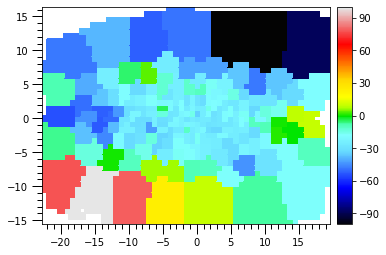

In [6]:
map_plotter = BayesLOSVD.get_map_plotter()
map_plotter(BayesLOSVD.data['v'],
            cmap='sauron',
            vmin=-100,
            vmax=100,
            colorbar=True)

The velocity map is not centered at 0. Let's center at the galaxy's systemic velocity. We could either provide this directly, or specify that we want the `flux_weighted` mean velocity calculated from the kinematic data itself,

In [7]:
BayesLOSVD.center_v_systemic(v_systemic='flux_weighted')
BayesLOSVD.save_data_table(outfile)

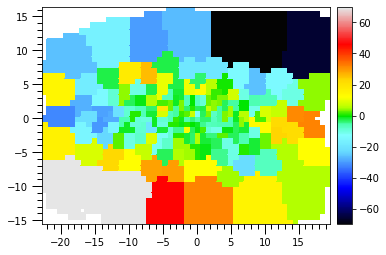

In [8]:
map_plotter(BayesLOSVD.data['v'],
            cmap='sauron',
            vmin=-70,
            vmax=70,
            colorbar=True)

And we can pick a specific bin, and plot the LOSVD there,

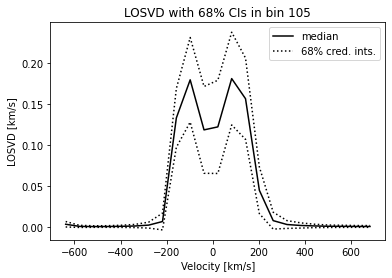

In [9]:
bin_id = 105

losvd_i = BayesLOSVD.data['losvd'][bin_id,:]
dlosvd_i = BayesLOSVD.data['dlosvd'][bin_id,:]
vcent = BayesLOSVD.data.meta['vcent']
plt.plot(vcent, losvd_i, '-k', label='median')
plt.plot(vcent, losvd_i+dlosvd_i, ':k', label='68% cred. ints.')
plt.plot(vcent, losvd_i-dlosvd_i, ':k')
plt.gca().set_xlabel('Velocity [km/s]')
plt.gca().set_ylabel('LOSVD [km/s]')
_ = plt.gca().set_title(f'LOSVD with 68% CIs in bin {bin_id}')
plt.gca().legend()
plt.show()

For `bin_id=105` we see that the galaxy has a bimodal LOSVD (albeit with quite large uncertainties).

The following are technical notes about BayesLOSVD data. If you're mainly interested in running DYNAMITE, you can skip below to the section [*Running DYNAMITE*](#run_dyn).

#### Note 1: bin ID's

The differences between `binID_BayesLOSVD` and `binID_DYNAMITE` are that: 
- `binID_BayesLOSVD` are zero-indexed, `binID_DYNAMITE` one-indexed. This is for compatibility with Fortran code,
- `binID_BayesLOSVD` may have some gaps (as some bins may be masked) while DYNAMITE assumes the binIDs increase without gaps
You shouldn't need to worry about this difference as bin IDs are handled internally, but be aware that of the difference for any later analysis.

#### Note 2: LOSVD normalisations

BayesLOSVD samples the multi-dimensional posterior on the LOSVD weights $L_i$. The full multidimensional posterior is not saved by defaut, however. What is saved, and what is given in the table above, is the median and 68% Bayesian credible intervals for the weight in each velocity bin.

One important effect of this is on LOSVD normalisation. The posterior samples created by BayesLOSVD are normnalised to 1 i.e. 

$$
\sum_i L_i = 1
$$

(this is acheieved by using the `simplex` datatype in STAN). The default results file, however, gives median values per velocity bin. These are *not* normalised the same way. Let's call these median value,

$$
l_i = \mathrm{median}(L_{i})
$$

and look at a histogram of the sums of the $l_i$ in each spatial bin,

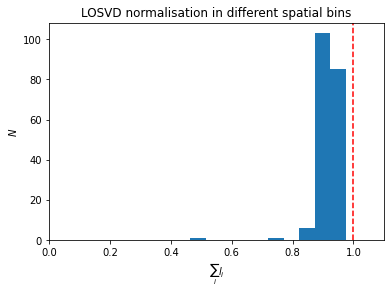

In [10]:
plt.hist(np.sum(BayesLOSVD.data['losvd'], 1))
plt.axvline(1., ls='--', color='r')
plt.gca().set_xlabel('$\sum_i l_{i}$')
plt.gca().set_ylabel('$N$')
plt.gca().set_xlim(0, 1.1)
_ = plt.gca().set_title('LOSVD normalisation in different spatial bins')

This peaks around 0.9 and, in some cases, is as low as 0.5. 

#### Note 3: calculating moments

When calculating LOSVD moments, we must acccount for the fact that LOSVDs are not normalised. Let's define the *normalised LOSVD* as

$$
\hat{l}_{i} = \frac{l_{i}}{\sum_i l_{i}}
$$

The quantity $\hat{l}_{i}$ is what we have used to make point estimates of the the LOSVD mean and standard deviation, which appear in the `v` and `sigma` columns of the data-table,

$$
v = \sum_i v_i * \hat{l}_{i}
$$

$$
\sigma = \left[ \sum_i (v_i-v)^2 * \hat{l}_{i} \right]^{\frac{1}{2}}
$$

#### Note 4: inflated velocity dispersions

Let's compare the BayesLOSVD result with a Gaussian LOSVD approximation in a particular bin,

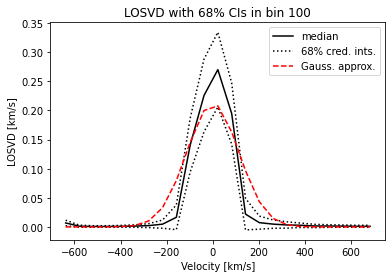

In [11]:
bin_id = 100

# plot BayesLOSVD result
losvd_i = BayesLOSVD.data['losvd'][bin_id,:]
dlosvd_i = BayesLOSVD.data['dlosvd'][bin_id,:]
vcent = BayesLOSVD.data.meta['vcent']
plt.plot(vcent, losvd_i, '-k', label='median')
plt.plot(vcent, losvd_i+dlosvd_i, ':k', label='68% cred. ints.')
plt.plot(vcent, losvd_i-dlosvd_i, ':k')

# plot Gaussian approximation
v = BayesLOSVD.data['v'][bin_id]
sigma = BayesLOSVD.data['sigma'][bin_id]
nrm = stats.norm(v, sigma)
pdf = nrm.pdf(vcent)
plt.gca().plot(vcent, pdf/np.sum(pdf), color='r', ls='--', label='Gauss. approx.')

# labels
plt.gca().set_xlabel('Velocity [km/s]')
plt.gca().set_ylabel('LOSVD [km/s]')
_ = plt.gca().set_title(f'LOSVD with 68% CIs in bin {bin_id}')
plt.gca().legend()
plt.show()

The Gaussian approximation is much wider then the median BayesLOSVD result. Why is this? Let's look at the this plot again, this time on a log-scale,

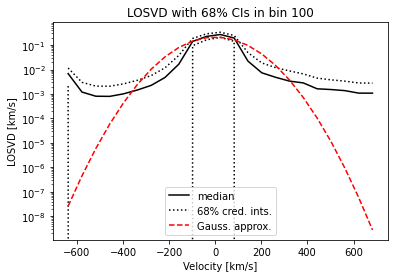

In [12]:
bin_id = 100

# plot BayesLOSVD result
losvd_i = BayesLOSVD.data['losvd'][bin_id,:]
dlosvd_i = BayesLOSVD.data['dlosvd'][bin_id,:]
vcent = BayesLOSVD.data.meta['vcent']
plt.plot(vcent, losvd_i, '-k', label='median')
plt.plot(vcent, losvd_i+dlosvd_i, ':k', label='68% cred. ints.')
plt.plot(vcent, losvd_i-dlosvd_i, ':k')

# plot Gaussian approximation
v = BayesLOSVD.data['v'][bin_id]
sigma = BayesLOSVD.data['sigma'][bin_id]
nrm = stats.norm(v, sigma)
pdf = nrm.pdf(vcent)
plt.gca().plot(vcent, pdf/np.sum(pdf), color='r', ls='--', label='Gauss. approx.')

# labels
plt.gca().set_xlabel('Velocity [km/s]')
plt.gca().set_ylabel('LOSVD [km/s]')
_ = plt.gca().set_title(f'LOSVD with 68% CIs in bin {bin_id}')
plt.gca().legend()
plt.gca().set_yscale('log')
plt.show()

We see that BayesLOSVD does not force the LOSVD to decay at large velocities. The fat tails give rise to large standard deviations. Therefore, the `sigma` values in the data table are unrepresentative of the width of the main body of the distribution.

For this reason, sigma-maps for BayesLOSVD output are not recommended. By default, for BayesLOSVD kinematic maps we will only plot mean velocities. In the future, we may extend this to plot LOSVD quantiles.

<a id="run_dyn"></a>
## Running DYNAMITE 

#### 1. Prepare the configuration file

Next prepare the DYNAMITE congfiguration file. We've included this file `NGC4550_config.yaml` in this directory. Here, we highlight a few importnat entries which are specific to fiting BayesLOSVD data. Firstly, we have to specify the type of the kinemtics as `BayesLOSVD`, i.e.

    system_components:
    ...
        stars:
            ...
            kinematics:
                sauron:
                    weight: 1.0
                    type: BayesLOSVD
                    datafile: "bayes_losvd_kins.ecsv"
                    aperturefile: "aperture.dat"
                    binfile: "bins.dat"

and ensure the `type` of the `weight_solver` is `NNLS` (since the aleternative, `LegacyWeightSolver` is incompatible with BayesLOSVD data), i.e.

    weight_solver_settings:
        type: "NNLS"
        lum_intr_rel_err: 0.01
        sb_proj_rel_err: 0.02
        nnls_solver: 'scipy'

Read the configuration file in,

In [13]:
c = dyn.config_reader.Configuration('NGC4550_config.yaml', reset_logging=True)

[INFO] 11:24:04 - dynamite.config_reader.Configuration - Config file NGC4550_config.yaml read.
[INFO] 11:24:04 - dynamite.config_reader.Configuration - io_settings...
[INFO] 11:24:04 - dynamite.config_reader.Configuration - system_attributes...
[INFO] 11:24:04 - dynamite.config_reader.Configuration - model_components...
[INFO] 11:24:04 - dynamite.config_reader.Configuration - system_parameters...
[INFO] 11:24:04 - dynamite.config_reader.Configuration - orblib_settings...
[INFO] 11:24:04 - dynamite.config_reader.Configuration - weight_solver_settings...
[INFO] 11:24:04 - dynamite.config_reader.Configuration - parameter_space_settings...
[INFO] 11:24:04 - dynamite.config_reader.Configuration - multiprocessing_settings...
[INFO] 11:24:04 - dynamite.config_reader.Configuration - ... using 4 CPUs for orbit integration.
[INFO] 11:24:04 - dynamite.config_reader.Configuration - ... using 4 CPUs for weight solving.
[INFO] 11:24:04 - dynamite.config_reader.Configuration - ... using iterator Mode

#### 2. Run the models

Currently, none of the automated plotting routines are compatible with BayesLOSVD data, so we must run the models with `plots=False` keyword set.

This will take around 15 minutes with 4 cpus.

In [ ]:
# delete previous output if available
c.remove_existing_orblibs()
c.remove_existing_all_models_file(wipe_other_files=False)
c.backup_config_file(keep=3, delete_other=True)

In [ ]:
import time

t = time.perf_counter()

mod_iter = dyn.model_iterator.ModelIterator(config=c, plots=False)

delta_t = time.perf_counter()-t
print(f'Computation time: {delta_t} seconds = {delta_t/60} minutes')

Look at the summary table,

In [14]:
c.all_models.table

m-black_hole,a-black_hole,c-dm_halo,f-dm_halo,q-stars,p-stars,u-stars,ml,chi2,kinchi2,time_modified,orblib_done,weights_done,all_done,which_iter,directory
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,bool,bool,bool,int64,object
1000000.0,0.001,10.0,1.0,0.1,0.99,0.9999,3.0,45254.77028546628,4662.895095316964,2021-12-03T12:34:20.000,True,True,True,0,orblib_000_000/ml3.00/
1000000.0,0.001,10.0,0.31622776601683794,0.1,0.99,0.9999,3.0,49077.812893798335,4680.910306046702,2021-12-03T12:37:50.000,True,True,True,1,orblib_001_000/ml3.00/
1000000.0,0.001,10.0,3.1622776601683795,0.1,0.99,0.9999,3.0,39666.1034326081,4647.504601468599,2021-12-03T12:37:50.000,True,True,True,1,orblib_001_001/ml3.00/
1000000.0,0.001,10.0,1.0,0.1,0.99,0.9999,2.0,46282.04961472527,5676.680111299871,2021-12-03T12:37:56.000,True,True,True,1,orblib_000_000/ml2.00/
1000000.0,0.001,10.0,1.0,0.1,0.99,0.9999,4.0,46245.06645726494,5649.872734261569,2021-12-03T12:37:56.000,True,True,True,1,orblib_000_000/ml4.00/
1000000.0,0.001,10.0,10.0,0.1,0.99,0.9999,3.0,45851.26367820718,4834.630523384587,2021-12-03T12:41:17.000,True,True,True,2,orblib_002_000/ml3.00/
1000000.0,0.001,10.0,3.1622776601683795,0.1,0.99,0.9999,2.0,40596.33546302577,5553.476109188877,2021-12-03T12:41:25.000,True,True,True,2,orblib_001_001/ml2.00/
1000000.0,0.001,10.0,3.1622776601683795,0.1,0.99,0.9999,4.0,40854.61895749207,5816.057318734439,2021-12-03T12:41:25.000,True,True,True,2,orblib_001_001/ml4.00/
1000000.0,0.001,10.0,1.7782794100389228,0.1,0.99,0.9999,3.0,43355.451901884015,4657.14971772537,2021-12-03T12:44:51.000,True,True,True,3,orblib_003_000/ml3.00/


#### 3. Plot the results

While we can't use the `dyn.plotter.Plotter` to create BayesLOSVD plots, we can manually create some.

Let's plot the evolution of the chi2 values against model ID

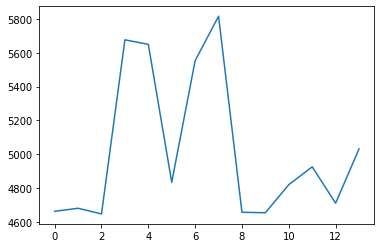

In [15]:
plt.plot(c.all_models.table['kinchi2'])

Let's plot the chi2 grid over the (only) two free parameters,

Text(0, 0.5, 'ml')

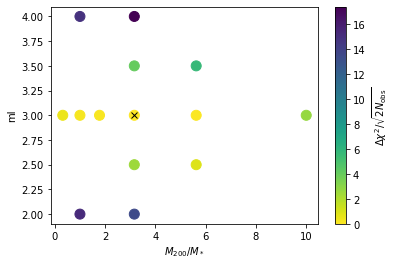

In [16]:
n_kin_dat = np.prod(BayesLOSVD.data['losvd'].shape)
sqrt_2n = np.sqrt(n_kin_dat)

min_chi2 = np.min(c.all_models.table['kinchi2'])
idx_min_chi2 = np.where(c.all_models.table['kinchi2'] == min_chi2)

x = c.all_models.table['f-dm_halo']
y = c.all_models.table['ml']
chi2 = c.all_models.table['kinchi2']
del_chi2 = chi2 - np.min(chi2)
red_del_chi2 = del_chi2/sqrt_2n
color = red_del_chi2

plt.scatter(x, y, c=color, cmap=plt.cm.viridis_r, s=100)
plt.plot(x[idx_min_chi2], y[idx_min_chi2], 'xk')

cbar = plt.colorbar()
cbar.set_label('$\Delta \chi^2 / \sqrt{2N_\mathrm{obs}}$')

plt.gca().set_xlabel('$M_{200}/M_*$')
plt.gca().set_ylabel('ml')

And now let's compare the best fit model to compare with the data. First let's get the model, and it's orbit library and best fitting weights,

In [17]:
row_min_chi2 = idx_min_chi2[0][0]
mod_min_chi2 = c.all_models.get_model_from_row(row_min_chi2)
orblib = mod_min_chi2.get_orblib()
weight_solver = mod_min_chi2.get_weights(orblib)
weights, chi2, kinchi2 = weight_solver.solve(orblib)

[INFO] 11:24:38 - dynamite.weight_solvers.NNLS - Using WeightSolver: NNLS/scipy
[INFO] 11:24:38 - dynamite.weight_solvers.NNLS - NNLS solution read from existing output
[INFO] 11:24:38 - dynamite.weight_solvers.NNLS - Using WeightSolver: NNLS/scipy
[INFO] 11:24:38 - dynamite.weight_solvers.NNLS - NNLS solution read from existing output


We can reconstruct the model losvd by taking the dot product of the losvds per orbit with the orbital weights,

In [18]:
model_losvd = np.dot(orblib.losvd_histograms[0].y.T, weights).T

Let's compare the projected surface density of the data and model,

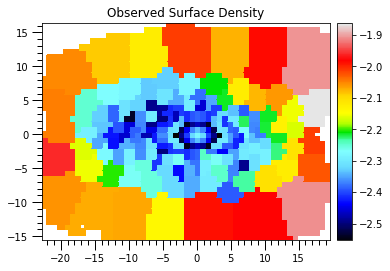

/Users/pjethwa/miniconda3/envs/dyn_env_py37/lib/python3.7/site-packages/matplotlib-3.3.4-py3.7-macosx-10.9-x86_64.egg/matplotlib/colors.py:576: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


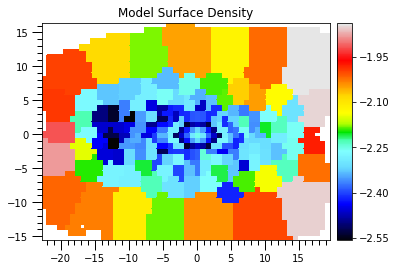

In [19]:
stars = c.system.get_component_from_name('stars')
mge = stars.mge_lum
obs_sd = mge.get_projected_masses_from_file(mod_min_chi2.directory_noml)
mod_sd = np.sum(model_losvd, 0)

# these are normalised differently - let's put them on the same scale:
obs_sd /= np.sum(obs_sd)
mod_sd /= np.sum(mod_sd)

# plot the surface density maps
map_plotter(np.log10(obs_sd), cmap='sauron', colorbar=True)
plt.gca().set_title('Observed Surface Density')
plt.show()

map_plotter(np.log10(mod_sd), cmap='sauron', colorbar=True)
plt.gca().set_title('Model Surface Density')
plt.show()

And next compare maps of mean velocity,

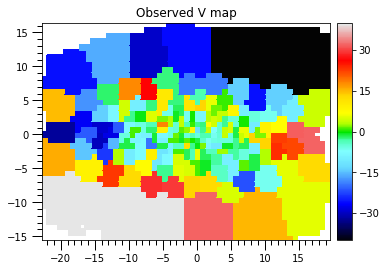

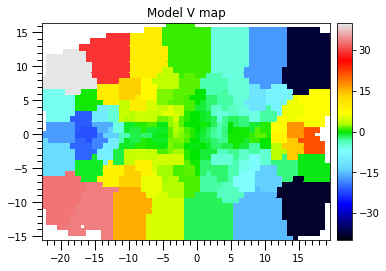

In [20]:
# plot the observed velocity map
map_plotter(BayesLOSVD.data['v'], cmap='sauron', colorbar=True, vmin=-40, vmax=40)
plt.gca().set_title('Observed V map')
plt.show()

# reconstruct a mean velocity from the model losvds
tmp = dyn.kinematics.Histogram(
    xedg=orblib.losvd_histograms[0].xedg,
    y=model_losvd[np.newaxis, :, :])
v_model = tmp.get_mean()[0]

# plot the model velocity map
map_plotter(v_model, cmap='sauron', colorbar=True, vmin=-40, vmax=40)
plt.gca().set_title('Model V map')
plt.show()

And finally plot the model vs observed LOSVDs in a number of bins,

In [21]:
def plot_model_vs_data_losvd(bin_id):
    losvd_i = BayesLOSVD.data['losvd'][bin_id,:]
    dlosvd_i = BayesLOSVD.data['dlosvd'][bin_id,:]
    vcent = BayesLOSVD.data.meta['vcent']
    dv = BayesLOSVD.data.meta['dv']
    plt.plot(vcent, losvd_i/dv, '-k', label='median')
    plt.plot(vcent, (losvd_i+dlosvd_i)/dv, ':k', label='68% cred. ints.')
    plt.plot(vcent, (losvd_i-dlosvd_i)/dv, ':k')
    plt.gca().set_xlabel('Velocity [km/s]')
    plt.gca().set_ylabel('LOSVD [km/s]')
    _ = plt.gca().set_title(f'LOSVD with 68% CIs in bin {bin_id}')
    y = model_losvd[:,bin_id]
    y /= np.sum(y*orblib.losvd_histograms[0].dx)
    plt.plot(orblib.losvd_histograms[0].x, y, '-r', label='model')
    plt.gca().set_xlim(-500, 500)
    plt.gca().legend()
    plt.show()

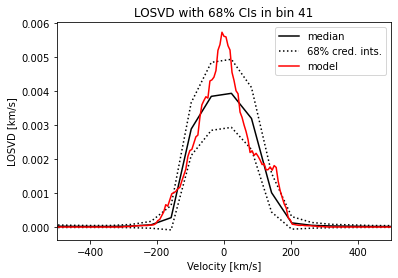

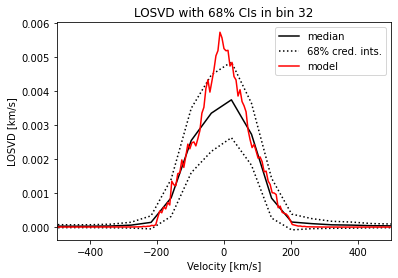

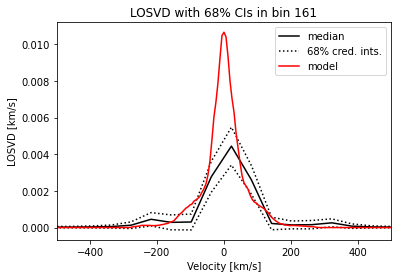

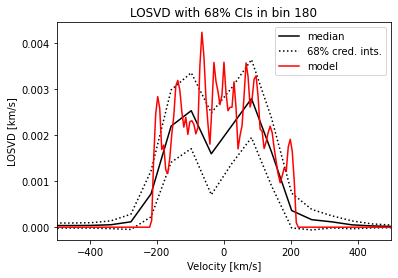

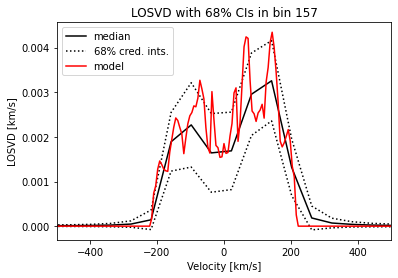

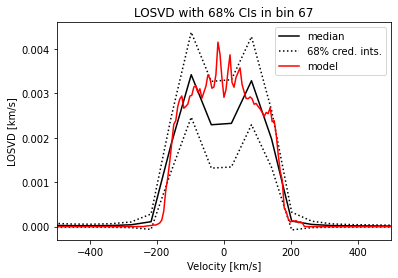

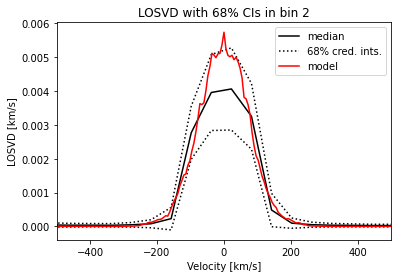

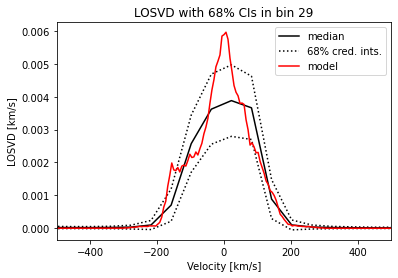

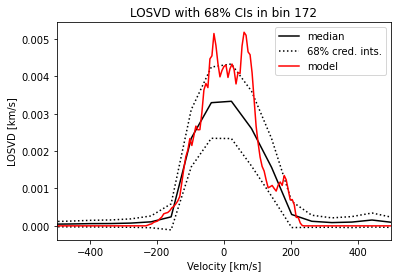

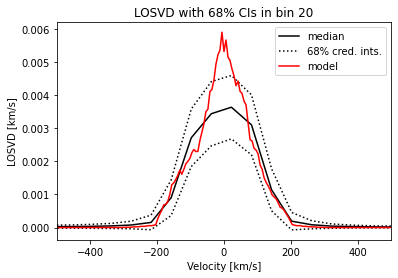

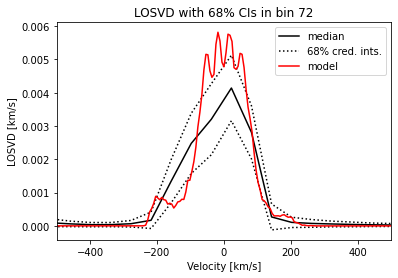

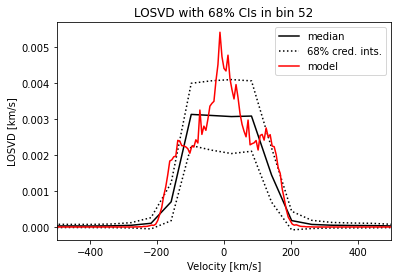

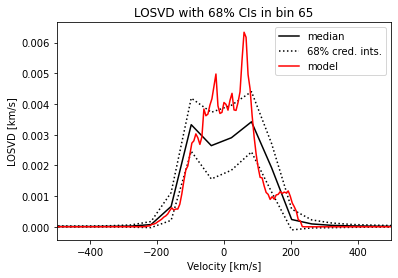

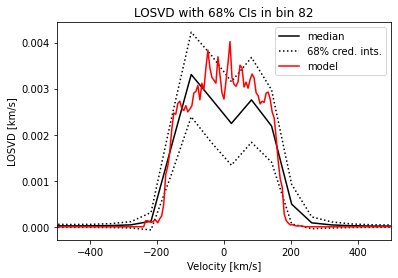

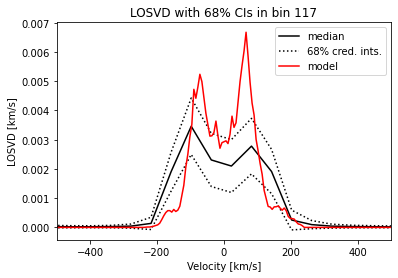

In [22]:
nbins = len(BayesLOSVD.data)
idx = np.random.choice(nbins, size=15, replace=False)
for bin_id in idx:
    plot_model_vs_data_losvd(bin_id)